In [1]:
import numpy as np
import pandas as pd

In [2]:
fb = pd.read_csv('fb_2018.csv', index_col = 'date', parse_dates=True)
fb.head()

,open,high,low,close,volume
date,,,,,
2018-01-02,177.68,181.58,177.5500,181.42,18151903
2018-01-03,181.88,184.78,181.3300,184.67,16886563
2018-01-04,184.90,186.21,184.0996,184.33,13880896
2018-01-05,185.59,186.90,184.9300,186.85,13574535
2018-01-08,187.20,188.90,186.3300,188.28,17994726


In [3]:
weather = pd.read_csv('nyc_weather_2018.csv', parse_dates=['date'])
weather.head()

,attributes,datatype,date,station,value
0,",,N,",PRCP,2018-01-01,GHCND:US1CTFR0039,0.0
1,",,N,",PRCP,2018-01-01,GHCND:US1NJBG0015,0.0
2,",,N,",SNOW,2018-01-01,GHCND:US1NJBG0015,0.0
3,",,N,",PRCP,2018-01-01,GHCND:US1NJBG0017,0.0
4,",,N,",SNOW,2018-01-01,GHCND:US1NJBG0017,0.0


In [4]:
# By default this is per column. Let's find the z-scores for the volume traded and look at the days where this was more than 3 ,
# standard deviations from the mean :
fb.assign(
    abs_z_score_volume=lambda x: x.volume.sub(x.volume.mean()).div(x.volume.std()).abs()
).query('abs_z_score_volume > 3')

,open,high,low,close,volume,abs_z_score_volume
date,,,,,,
2018-03-19,177.01,177.17,170.06,172.56,88140060,3.145078
2018-03-20,167.47,170.20,161.95,168.15,129851768,5.315169
2018-03-21,164.80,173.40,163.30,169.39,106598834,4.105413
2018-03-26,160.82,161.10,149.02,160.06,126116634,5.120845
2018-07-26,174.89,180.13,173.75,176.26,169803668,7.393705


In [5]:
# We can use rank() and pct_change() to see which days had the largest change in volume traded from the day before:
fb.assign(
    volume_pct_change=fb.volume.pct_change(),
    pct_change_rank=lambda x: x.volume_pct_change.abs().rank(
        ascending=False
    )
).nsmallest(5, 'pct_change_rank')

,open,high,low,close,volume,volume_pct_change,pct_change_rank
date,,,,,,,
2018-01-12,178.06,181.48,177.40,179.37,77551299,7.087876,1.0
2018-03-19,177.01,177.17,170.06,172.56,88140060,2.611789,2.0
2018-07-26,174.89,180.13,173.75,176.26,169803668,1.628841,3.0
2018-09-21,166.64,167.25,162.81,162.93,45994800,1.428956,4.0
2018-03-26,160.82,161.10,149.02,160.06,126116634,1.352496,5.0


January 12th was when the news that Facebook changed its news feed product to focus more on content from a users' friends over the brands they follow. Given that Facebook's advertising is a key component of its business (nearly 89% in 2017), many shares were sold and the price dropped in panic:

In [6]:
fb['2018-01-11':'2018-01-12']

,open,high,low,close,volume
date,,,,,
2018-01-11,188.40,188.40,187.38,187.77,9588587
2018-01-12,178.06,181.48,177.40,179.37,77551299


Throughout 2018, Facebook's stock price never had a low above $215:

In [7]:
(fb > 215).any()

open       True
high       True
low       False
close      True
volume     True
dtype: bool

Binning and thresholds
When working with the volume traded, we may be interested in ranges of volume rather than the exact values. No two days have the same volume traded:

In [8]:
(fb.volume.value_counts() > 1).sum()

0

We can use pd.cut() to create 3 bins of even an even range in volume traded and name them. Then we can work with low, medium, and high volume traded categories:

In [9]:
volume_binned = pd.cut(fb.volume, bins=3, labels=['low', 'med', 'high'])
volume_binned.value_counts()

volume
low     240
med       8
high      3
Name: count, dtype: int64

In [10]:
fb[volume_binned == 'high'].sort_values(
    'volume', ascending=False
)

,open,high,low,close,volume
date,,,,,
2018-07-26,174.89,180.13,173.75,176.26,169803668
2018-03-20,167.47,170.20,161.95,168.15,129851768
2018-03-26,160.82,161.10,149.02,160.06,126116634


Cambridge Analytica scandal broke on Saturday March 17th, so we look to the Monday for the numbers:

In [11]:
fb['2018-03-16':'2018-03-20']

,open,high,low,close,volume
date,,,,,
2018-03-16,184.49,185.33,183.41,185.09,24403438
2018-03-19,177.01,177.17,170.06,172.56,88140060
2018-03-20,167.47,170.20,161.95,168.15,129851768


Since most days have similar volume, but a few are very large, we have very wide bins. Most of the data is in the low bin.

Note: visualizations will be covered in chapters 5 and 6.

In [12]:
import matplotlib.pyplot as plt

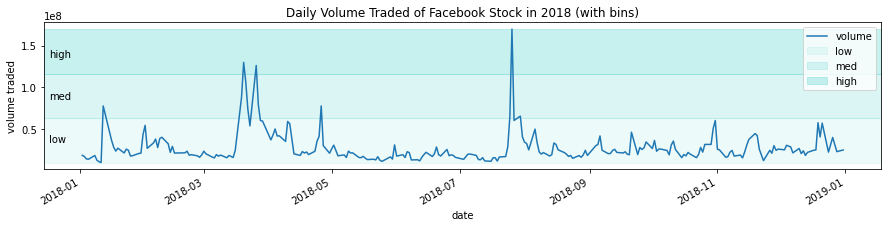

In [13]:
fb.plot(y='volume', figsize=(15, 3), title='Daily Volume Traded of Facebook Stock in 2018 (with bins)')

for bin_name, alpha, bounds in zip(
    ['low', 'med', 'high'], [0.1, 0.2, 0.3], pd.cut(fb.volume, bins=3).unique().categories.values
):
    plt.axhspan(bounds.left, bounds.right, alpha=alpha, label=bin_name, color='mediumturquoise')
    plt.annotate(bin_name, xy=('2017-12-17', (bounds.left + bounds.right)/2.1))
    
plt.ylabel('volume traded')
plt.legend()
plt.show()

If we split using quantiles, the bins will have roughly the same number of observations. For this, we use qcut(). We will make 4 quartiles:

In [14]:
volume_qbinned = pd.qcut(fb.volume, q=4, labels=['q1', 'q2', 'q3', 'q4'])
volume_qbinned.value_counts()

volume
q1    63
q2    63
q4    63
q3    62
Name: count, dtype: int64

Notice the bins don't cover ranges of the same size anymore:

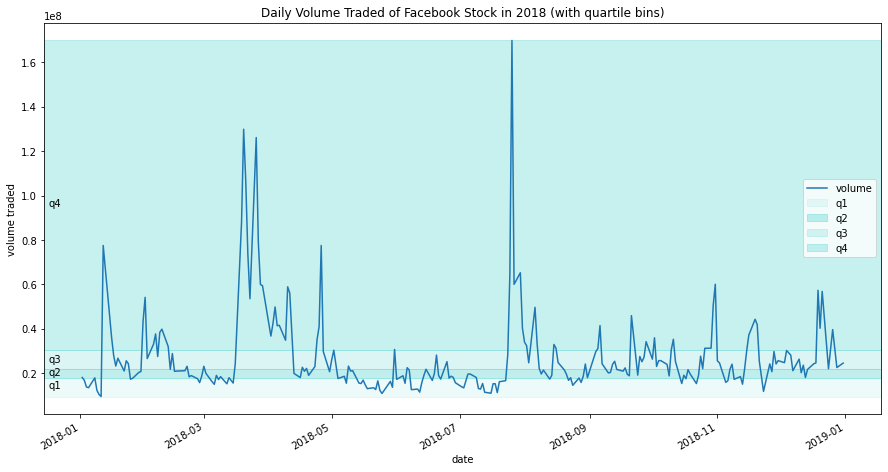

In [15]:
fb.plot(y='volume', figsize=(15, 8), title='Daily Volume Traded of Facebook Stock in 2018 (with quartile bins)')

for bin_name, alpha, bounds in zip(
    ['q1', 'q2', 'q3', 'q4'], [0.1, 0.35, 0.2, 0.3], pd.qcut(fb.volume, q=4).unique().categories.values
):
    plt.axhspan(bounds.left, bounds.right, alpha=alpha, label=bin_name, color='mediumturquoise')
    plt.annotate(bin_name, xy=('2017-12-17', (bounds.left + bounds.right)/2.1))
    
plt.ylabel('volume traded')
plt.legend()
plt.show()

Sometimes we don't want to make bins, but rather cap values at a threshold. Before we look at an example, let's pivot our weather data for the Central Park station:

In [16]:
central_park_weather = weather.query(
    'station == "GHCND:USW00094728"'
).pivot(index='date', columns='datatype', values='value')

In [17]:
central_park_weather.head()

datatype,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT06,WT08
date,,,,,,,,,,,,,,,
2018-01-01,3.5,0.0,0.0,0.0,-7.1,-13.8,300.0,300.0,6.7,11.2,NaN,NaN,NaN,NaN,NaN
2018-01-02,3.6,0.0,0.0,0.0,-3.2,-10.5,260.0,250.0,7.2,12.5,NaN,NaN,NaN,NaN,NaN
2018-01-03,1.4,0.0,0.0,0.0,-1.0,-8.8,260.0,270.0,6.3,9.8,NaN,NaN,NaN,NaN,NaN
2018-01-04,5.6,19.3,249.0,30.0,-1.6,-7.1,310.0,310.0,10.7,19.2,1.0,1.0,NaN,NaN,1.0
2018-01-05,5.8,0.0,0.0,180.0,-7.1,-12.7,280.0,280.0,9.4,15.7,NaN,NaN,NaN,NaN,NaN


Say we don't care how much snow their was, just that it snowed in Central Park. However, we don't want to make a Boolean column since we need to preserve the data type of float. We can use clip() to replace values above a upper threshold with the threshold and replace values below a lower threshold with the lower threshold. This means we can use clip(0, 1) to change all the snow values of one or more to 1, which easily shows us the days snow was recorded in Central Park. Preserving the data type will save some work later on if we are building a model:

In [18]:
central_park_weather.SNOW.clip(0, 1).value_counts()

SNOW
0.0    354
1.0     11
Name: count, dtype: int64

Note: the clip() method can also be called on the dataframe itself.

Applying Functions
We can use the apply() method to run the same operation on all columns (or rows) of the dataframe. Let's calculate the z-scores of the TMIN, TMAX, and PRCP observations in Central Park in October 2018:

In [19]:
oct_weather_z_scores = central_park_weather.loc[
    '2018-10', ['TMIN', 'TMAX', 'PRCP']
].apply(lambda x: x.sub(x.mean()).div(x.std()))
oct_weather_z_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
datatype,,,,,,,,
TMIN,31.0,-1.790682e-16,1.0,-1.339112,-0.751019,-0.474269,1.065152,1.843511
TMAX,31.0,1.951844e-16,1.0,-1.305582,-0.870013,-0.138258,1.011643,1.604016
PRCP,31.0,4.655774e-17,1.0,-0.394438,-0.394438,-0.394438,-0.240253,3.936167


October 27th rained much more than the rest of the days:

In [20]:
oct_weather_z_scores.query('PRCP > 3')

datatype,TMIN,TMAX,PRCP
date,,,
2018-10-27,-0.751019,-1.201045,3.936167


Indeed, this day was much higher than the rest:

In [21]:
central_park_weather.loc['2018-10', 'PRCP'].describe()

count    31.000000
mean      2.941935
std       7.458542
min       0.000000
25%       0.000000
50%       0.000000
75%       1.150000
max      32.300000
Name: PRCP, dtype: float64

When the function we want to apply isn't vectorized, we can:

use np.vectorize() to vectorize it (similar to how map() works) and then use it with apply()
use applymap() and pass it the non-vectorized function directly
Say we wanted to count the digits of the whole numbers for the Facebook data. len() is not vectorized:

In [22]:
import numpy as np

fb.apply(
    lambda x: np.vectorize(lambda y: len(str(np.ceil(y))))(x)
).astype('int64').equals(
    fb.applymap(lambda x: len(str(np.ceil(x))))
)

/tmp/ipykernel_1442/1424693223.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  fb.applymap(lambda x: len(str(np.ceil(x))))


True

A simple operation of addition to each element in a series grows linearly in time complexity when using items(), but stays near 0 when using vectorized operations. items() and related methods should only be used if there is no vectorized solution:

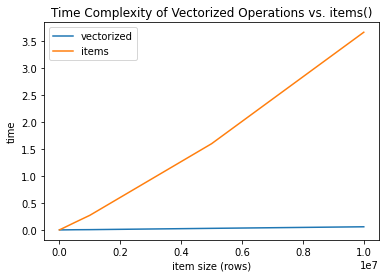

In [23]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.random.seed(0)

vectorized_results = {}
iteritems_results = {}

for size in [10, 100, 1000, 10000, 100000, 500000, 1000000, 5000000, 10000000]:
    test = pd.Series(np.random.uniform(size=size))
    
    start = time.time()
    x = test + 10
    end = time.time()
    vectorized_results[size] = end - start
    
    start = time.time()
    x = []
    for i, v in test.items():
        x.append(v + 10)
    x = pd.Series(x)
    end = time.time()
    iteritems_results[size] = end - start

pd.DataFrame(
    [pd.Series(vectorized_results, name='vectorized'), pd.Series(iteritems_results, name='items')]
).T.plot(title='Time Complexity of Vectorized Operations vs. items()')
plt.xlabel('item size (rows)')
plt.ylabel('time')
plt.show()

Window Calculations
Consult the understanding_window_calculations.ipynb notebook for interactive visualizations to help understand window calculations.

The rolling() method allows us to perform rolling window calculations. We simply specify the window size (3 days here) and follow it with a call to an aggregation function (sum here):

In [24]:
import pandas as pd

# Ensure the DataFrame has a DateTime index
central_park_weather.index = pd.to_datetime(central_park_weather.index)

# Check the date range in the DataFrame
print(central_park_weather.index.min(), central_park_weather.index.max())

# Use date slicing to select data for October 2018
october_data = central_park_weather.loc['2018-10']

# Calculate the rolling sum
result = october_data.assign(
    rolling_PRCP=lambda x: x['PRCP'].rolling('3D').sum()
)[['PRCP', 'rolling_PRCP']].head(7).T

print(result)


2018-01-01 00:00:00 2018-12-31 00:00:00
date          2018-10-01  2018-10-02  2018-10-03  2018-10-04  2018-10-05  \
datatype                                                                   
PRCP                 0.0        17.5         0.0         1.0         0.0   
rolling_PRCP         0.0        17.5        17.5        18.5         1.0   

date          2018-10-06  2018-10-07  
datatype                              
PRCP                 0.0         0.0  
rolling_PRCP         1.0         0.0  


In [25]:
import pandas as pd

# Ensure the DataFrame has a DateTime index
central_park_weather.index = pd.to_datetime(central_park_weather.index)

# Use date slicing to select data for October 2018
october_data = central_park_weather.loc['2018-10']

# Calculate the rolling sum
result = october_data.assign(
    rolling_PRCP=lambda x: x['PRCP'].rolling('3D').sum()
)[['PRCP', 'rolling_PRCP']].head(7).T

print(result)


date          2018-10-01  2018-10-02  2018-10-03  2018-10-04  2018-10-05  \
datatype                                                                   
PRCP                 0.0        17.5         0.0         1.0         0.0   
rolling_PRCP         0.0        17.5        17.5        18.5         1.0   

date          2018-10-06  2018-10-07  
datatype                              
PRCP                 0.0         0.0  
rolling_PRCP         1.0         0.0  


In [26]:
import pandas as pd

# Ensure the DataFrame has a DateTime index
central_park_weather.index = pd.to_datetime(central_park_weather.index)

# Use date slicing to select data for October 2018
october_data = central_park_weather.loc['2018-10']

# Calculate the rolling mean
result = october_data.rolling('3D').mean().head(7)

print(result)


datatype        AWND      PRCP  SNOW  SNWD       TMAX       TMIN        WDF2  \
date                                                                           
2018-10-01  0.900000  0.000000   0.0   0.0  24.400000  17.200000  240.000000   
2018-10-02  0.900000  8.750000   0.0   0.0  24.700000  17.750000  270.000000   
2018-10-03  0.966667  5.833333   0.0   0.0  24.233333  17.566667  276.666667   
2018-10-04  0.800000  6.166667   0.0   0.0  24.233333  17.200000  273.333333   
2018-10-05  1.033333  0.333333   0.0   0.0  23.133333  16.300000  180.000000   
2018-10-06  0.833333  0.333333   0.0   0.0  22.033333  16.300000  163.333333   
2018-10-07  1.066667  0.000000   0.0   0.0  22.600000  17.400000  176.666667   

datatype          WDF5      WSF2      WSF5  WT01  WT02  WT03  WT06  WT08  
date                                                                      
2018-10-01  230.000000  4.000000  7.200000   NaN   NaN   NaN   NaN   NaN  
2018-10-02  270.000000  5.150000  8.950000   1.0   NaN

We can use different aggregation functions per column if we use agg() instead. We pass in a dictionary mapping the column to the aggregation to perform on it:

In [27]:
central_park_weather['2018-10-01':'2018-10-07'].rolling('3D').agg(
    {'TMAX': 'max', 'TMIN': 'min', 'AWND': 'mean', 'PRCP': 'sum'}
).join( # join with original data for comparison
    central_park_weather[['TMAX', 'TMIN', 'AWND', 'PRCP']], 
    lsuffix='_rolling'
).sort_index(axis=1) # sort columns so rolling calcs are next to originals

datatype,AWND,AWND_rolling,PRCP,PRCP_rolling,TMAX,TMAX_rolling,TMIN,TMIN_rolling
date,,,,,,,,
2018-10-01,0.9,0.900000,0.0,0.0,24.4,24.4,17.2,17.2
2018-10-02,0.9,0.900000,17.5,17.5,25.0,25.0,18.3,17.2
2018-10-03,1.1,0.966667,0.0,17.5,23.3,25.0,17.2,17.2
2018-10-04,0.4,0.800000,1.0,18.5,24.4,25.0,16.1,16.1
2018-10-05,1.6,1.033333,0.0,1.0,21.7,24.4,15.6,15.6
2018-10-06,0.5,0.833333,0.0,1.0,20.0,24.4,17.2,15.6
2018-10-07,1.1,1.066667,0.0,0.0,26.1,26.1,19.4,15.6


Rolling calculations (rolling()) use a sliding window. Expanding calculations (expanding()) however grow in size. These are equivalent to cumulative aggregations like cumsum(); however, we can specify the minimum number of periods required to start calculating (default is 1):

In [28]:
central_park_weather.PRCP.expanding().sum().equals(central_park_weather.PRCP.cumsum())

False

Separate expanding aggregations per column. Note that agg() will accept numpy functions too:

In [29]:
central_park_weather['2018-10-01':'2018-10-07'].expanding().agg(
    {'TMAX': np.max, 'TMIN': np.min, 'AWND': np.mean, 'PRCP': np.sum}
).join(
    central_park_weather[['TMAX', 'TMIN', 'AWND', 'PRCP']], 
    lsuffix='_expanding'
).sort_index(axis=1)

/tmp/ipykernel_1442/1208072281.py:1: FutureWarning: The provided callable <function amax at 0x7ff1b80b81f0> is currently using Expanding.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  central_park_weather['2018-10-01':'2018-10-07'].expanding().agg(
/tmp/ipykernel_1442/1208072281.py:1: FutureWarning: The provided callable <function amin at 0x7ff1b80b83a0> is currently using Expanding.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  central_park_weather['2018-10-01':'2018-10-07'].expanding().agg(
/tmp/ipykernel_1442/1208072281.py:1: FutureWarning: The provided callable <function mean at 0x7ff1b80b8dc0> is currently using Expanding.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  central_park_weather['2018-10-01':'2018-

datatype,AWND,AWND_expanding,PRCP,PRCP_expanding,TMAX,TMAX_expanding,TMIN,TMIN_expanding
date,,,,,,,,
2018-10-01,0.9,0.900000,0.0,0.0,24.4,24.4,17.2,17.2
2018-10-02,0.9,0.900000,17.5,17.5,25.0,25.0,18.3,17.2
2018-10-03,1.1,0.966667,0.0,17.5,23.3,25.0,17.2,17.2
2018-10-04,0.4,0.825000,1.0,18.5,24.4,25.0,16.1,16.1
2018-10-05,1.6,0.980000,0.0,18.5,21.7,25.0,15.6,15.6
2018-10-06,0.5,0.900000,0.0,18.5,20.0,25.0,17.2,15.6
2018-10-07,1.1,0.928571,0.0,18.5,26.1,26.1,19.4,15.6


We can calculate the exponentially weighted moving average as follows. Note that span here is the periods to use:

In [30]:
fb.assign(
    close_ewma=lambda x: x.close.ewm(span=5).mean()
).tail(10)[['close', 'close_ewma']]

,close,close_ewma
date,,
2018-12-17,140.19,142.235433
2018-12-18,143.66,142.710289
2018-12-19,133.24,139.553526
2018-12-20,133.40,137.502350
2018-12-21,124.95,133.318234
2018-12-24,124.06,130.232156
2018-12-26,134.18,131.548104
2018-12-27,134.52,132.538736
2018-12-28,133.20,132.759157


Pipes
Pipes all use to apply any function that accepts our data as the first argument and pass in any additional arguments. This makes it easy to chain steps together regardless of if they are methods or functions:

We can pass any function that will accept the caller of pipe() as the first argument:

In [31]:
import pandas as pd

# Ensure the DataFrame has a DateTime index
fb.index = pd.to_datetime(fb.index)

# Use date slicing to select data for the first quarter of 2018
q1_data = fb.loc['2018-01-01':'2018-03-31']

# Apply z-score normalization and use pipe to pass the result to get_info
result_with_pipe = q1_data.apply(lambda x: (x - x.mean()) / x.std()).pipe(get_info)

# Apply z-score normalization and directly pass the result to get_info
result_direct = get_info(q1_data.apply(lambda x: (x - x.mean()) / x.std()))

# Compare the results
comparison = result_with_pipe == result_direct

print(result_with_pipe)
print(result_direct)
print(comparison)


NameError: name 'get_info' is not defined

In [ ]:
fb.pipe(pd.DataFrame.rolling, '20D').mean().equals(fb.rolling('20D').mean())

The pipe takes the function passed in and calls it with the object that called pipe() as the first argument. Positional and keyword arguments are passed down:

In [ ]:
pd.DataFrame.rolling(fb, '20D').mean().equals(fb.rolling('20D').mean())

In [ ]:
def window_calc(df, func, agg_dict, *args, **kwargs):
    """
    Run a window calculation of your choice on a DataFrame.
    
    Parameters:
        - df: The DataFrame to run the calculation on.
        - func: The window calculation method that takes df 
                as the first argument.
        - agg_dict: Information to pass to `agg()`, could be a 
                    dictionary mapping the columns to the aggregation 
                    function to use, a string name for the function, 
                    or the function itself.
        - args: Positional arguments to pass to `func`.
        - kwargs: Keyword arguments to pass to `func`.
    
    Returns:
        - A new DataFrame object.
    """
    return df.pipe(func, *args, **kwargs).agg(agg_dict)

In [ ]:
window_calc(fb, pd.DataFrame.expanding, np.median).head()

Using the exponentially weighted moving average requires we pass in a keyword argument:

In [ ]:
window_calc(fb, pd.DataFrame.ewm, 'mean', span=3).head()

In [ ]:
window_calc(
    central_park_weather.loc['2018-10'], 
    pd.DataFrame.rolling, 
    {'TMAX': 'max', 'TMIN': 'min', 'AWND': 'mean', 'PRCP': 'sum'},
    '3D'
).head()